In [1]:
from datasets import load_dataset
import os
from transformers import AutoFeatureExtractor
import evaluate
import pandas as pd
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt

/Users/mateuszw/files/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOADING DATASET

In [2]:

# Custom filter to ignore _background_noise_
def filter_noise(example):
    return "_background_noise_" not in example["file"]

# Load all .wav files with directory names as labels
dataset = load_dataset(
    
    "audiofolder",
    data_dir="audio_data/train/audio"
)['train']

# Filter out the background noise folder
dataset = dataset.filter(lambda ex: "_background_noise_" not in ex["audio"]["path"])

labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

def add_label_str(example):
    example["label_str"] = id2label[str(example["label"])]
    return example

dataset = dataset.map(add_label_str)

def load_split_list(txt_path):
    with open(txt_path, "r") as f:
        return [line.strip() for line in f.readlines()]
        
test_list = load_split_list("audio_data/train/testing_list.txt")
val_list = load_split_list("audio_data/train/validation_list.txt")

def get_split(dataset, split_list):
    
    split_set = set(split_list)

    def is_in_split(example):
        return '/'.join(example['audio']['path'].split('/')[-2:]) in split_set

    return dataset.filter(is_in_split)

val_dataset = get_split(dataset, val_list)
test_dataset = get_split(dataset, test_list)

# Train = everything else
used_paths = set(val_list + test_list)
train_dataset = dataset.filter(
    lambda example: '/'.join(example['audio']['path'].split('/')[-2:]) not in used_paths
)


## LOADING MODEL AND PREDICTION

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("wav2vec2_final_model")
model = AutoModelForAudioClassification.from_pretrained("wav2vec2_final_model")

predictions = []
for sample in test_dataset:
    audio_array = sample['audio']['array']
    inputs = feature_extractor(audio_array, sampling_rate=16000, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = torch.argmax(logits).item()
    predictions.append(predicted_class_id)

# 4 min

## EVALUATION

Accuracy: 0.9757132406730066


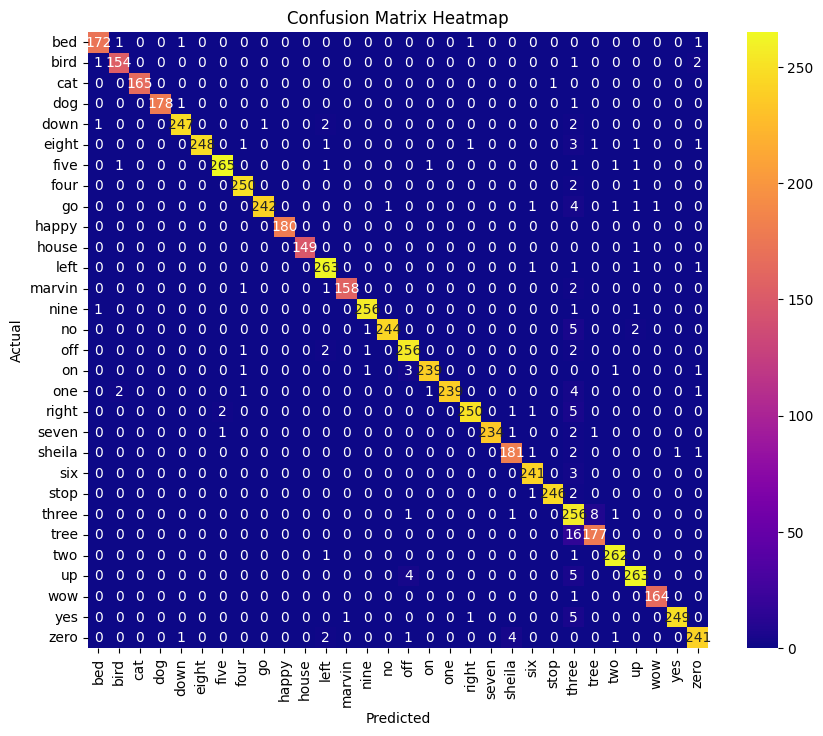

In [ ]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

accuracy = evaluate.load("accuracy")
confusion_matrix = evaluate.load("confusion_matrix")

references = test_dataset['label']

labels = [id2label[str(class_)] for class_ in sorted(list(set(references) | set(predictions)))]

print('Accuracy: {}'.format(accuracy.compute(references=references, predictions=predictions)['accuracy']))
# display(pd.DataFrame(confusion_matrix.compute(references=references, predictions=predictions)['confusion_matrix'], columns=labels, index=labels))

conf_matrix = confusion_matrix.compute(references=references, predictions=predictions)['confusion_matrix']
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="plasma") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()



In [ ]:
import pandas as pd

matches = df_cm[(df_cm > 2) & (df_cm < 100)]
result = matches.stack().reset_index()
result.columns = ['real_class', 'predicted_class', 'value']

print(result)
print("Total count:", len(result))

# Tree and Three pair is most problematic


   real_class predicted_class  value
0       eight           three    3.0
1          go           three    4.0
2          no           three    5.0
3          on             off    3.0
4         one           three    4.0
5       right           three    5.0
6         six           three    3.0
7       three            tree    8.0
8        tree           three   16.0
9          up             off    4.0
10         up           three    5.0
11        yes           three    5.0
12       zero          sheila    4.0
Total count: 13
